# Accuracy Benchmark

In [ ]:
!pip install pymatching beliefmatching stim

In [65]:
import pathlib
import time
import yaml
import stim
import pymatching
import beliefmatching
import matplotlib.pyplot as plt

In [6]:
data_dir = pathlib.Path("/home/inm/WorkDir/QEC/paper_data/google_qec3v5_experiment_data/")

## Google's baseline

In [48]:
# select a single d=3 patch
d3_center = "5_7"
all_d3_subdir = [
    x for x in data_dir.iterdir()
    if x.is_dir() and f"d3" in x.name and "bX" in x.name and d3_center in x.name
]
all_d3_subdir = sorted(all_d3_subdir, key=lambda x: int(x.name.split('_')[4][1:]))
assert len(all_d3_subdir) == 13
# d=5
all_d5_subdir = [
    x for x in data_dir.iterdir()
    if x.is_dir() and f"d5" in x.name and "bX" in x.name
]
all_d5_subdir = sorted(all_d5_subdir, key=lambda x: int(x.name.split('_')[4][1:]))
assert len(all_d5_subdir) == 13

all_rounds = list(range(1, 26, 2))

In [29]:
def get_google_baseline(dirs):
    results = {"pymatching": [], "correlated": [], "belief_matching": [], "tensor_network_contraction": []}
    for sub_dir in dirs:
        actual_flips = stim.read_shot_data_file(path=sub_dir / "obs_flips_actual.01", format="01", num_observables=1)
        pymatching_predictions = stim.read_shot_data_file(path=sub_dir / "obs_flips_predicted_by_pymatching.01", format="01", num_observables=1)
        correlated_predictions = stim.read_shot_data_file(path=sub_dir / "obs_flips_predicted_by_correlated_matching.01", format="01", num_observables=1)
        belief_matching_predictions = stim.read_shot_data_file(path=sub_dir / "obs_flips_predicted_by_belief_matching.01", format="01", num_observables=1)
        tensor_network_predictions = stim.read_shot_data_file(path=sub_dir / "obs_flips_predicted_by_tensor_network_contraction.01", format="01", num_observables=1)
        results["pymatching"].append(1 - 2 * (actual_flips ^ pymatching_predictions).mean())
        results["correlated"].append(1 - 2 * (actual_flips ^ correlated_predictions).mean())
        results["belief_matching"].append(1 - 2 * (actual_flips ^ belief_matching_predictions).mean())
        results["tensor_network_contraction"].append(1 - 2 * (actual_flips ^ tensor_network_predictions).mean())
    return results

In [30]:
d3_baseline = get_google_baseline(all_d3_subdir)
d5_baseline = get_google_baseline(all_d5_subdir)

## Benchmark

### Pymatching

In [56]:
def pymatching_decode(dirs):
    fidelities = []
    for sub_dir in dirs:
        with open(sub_dir / "properties.yml") as f:
            properties = yaml.load(f, Loader=yaml.SafeLoader)
        num_detectors = properties["circuit_detectors"]
        actual_flips = stim.read_shot_data_file(path=sub_dir / "obs_flips_actual.01", format="01", num_observables=1)
        detection_events = stim.read_shot_data_file(path=sub_dir / "detection_events.b8", format="b8", num_detectors=num_detectors)
        matching = pymatching.Matching.from_detector_error_model_file(str(sub_dir / "circuit_detector_error_model.dem"))
        predictions = matching.decode_batch(detection_events)
        # matching_even = pymatching.Matching.from_detector_error_model_file(str(sub_dir / "pij_from_odd_for_even.dem"))
        # matching_odd = pymatching.Matching.from_detector_error_model_file(str(sub_dir / "pij_from_even_for_odd.dem"))
        # even_predictions = matching_even.decode_batch(detection_events[::2])
        # odd_predictions = matching_odd.decode_batch(detection_events[1::2])
        # fidelity = 1 - 2 * ((even_predictions ^ actual_flips[::2]).sum() + (odd_predictions ^ actual_flips[1::2]).sum()) / len(actual_flips)
        fidelity = 1 - 2 * (predictions ^ actual_flips).mean()
        fidelities.append(fidelity)
    return fidelities
        
    

In [57]:
pymatching_fidelities_d3 = pymatching_decode(all_d3_subdir)
pymatching_fidelities_d5 = pymatching_decode(all_d5_subdir)


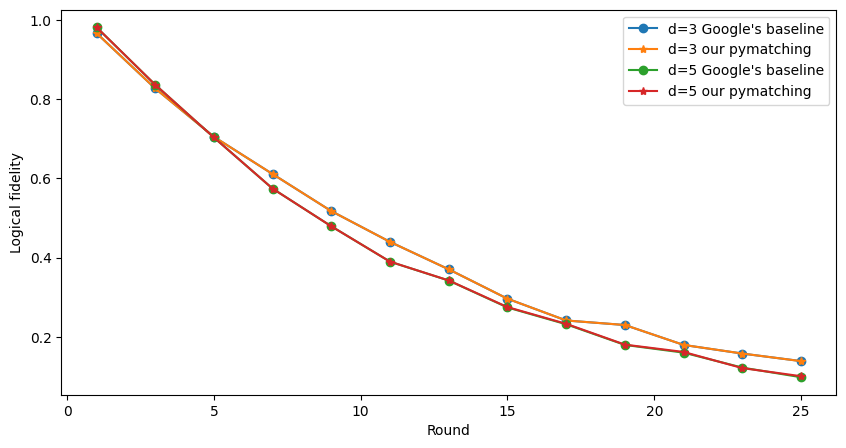

In [58]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(all_rounds, d3_baseline["pymatching"], label="d=3 Google's baseline", marker='o')
ax.plot(all_rounds, pymatching_fidelities_d3, label="d=3 our pymatching", marker='*')
ax.plot(all_rounds, d5_baseline["pymatching"], label="d=5 Google's baseline", marker='o')
ax.plot(all_rounds, pymatching_fidelities_d5, label="d=5 our pymatching", marker='*')
ax.set_xlabel("Round")
ax.set_ylabel("Logical fidelity")
ax.legend()


### Belief Matching

In [66]:
def belief_matching_decode(dirs):
    fidelities = []
    for sub_dir in dirs:
        with open(sub_dir / "properties.yml") as f:
            properties = yaml.load(f, Loader=yaml.SafeLoader)
        start = time.perf_counter()
        num_detectors = properties["circuit_detectors"]
        actual_flips = stim.read_shot_data_file(path=sub_dir / "obs_flips_actual.01", format="01", num_observables=1)
        detection_events = stim.read_shot_data_file(path=sub_dir / "detection_events.b8", format="b8", num_detectors=num_detectors)
        dem_odd_for_even = stim.DetectorErrorModel.from_file(sub_dir / "pij_from_odd_for_even.dem")
        dem_even_for_odd = stim.DetectorErrorModel.from_file(sub_dir / "pij_from_even_for_odd.dem")
        decoder_even = beliefmatching.BeliefMatching.from_detector_error_model(dem_odd_for_even, max_bp_iters=5)
        decoder_odd = beliefmatching.BeliefMatching.from_detector_error_model(dem_even_for_odd, max_bp_iters=5)
        even_predictions = decoder_even.decode_batch(detection_events[::2])
        odd_predictions = decoder_odd.decode_batch(detection_events[1::2])
        fidelity = 1 - 2 * ((even_predictions ^ actual_flips[::2]).sum() + (odd_predictions ^ actual_flips[1::2]).sum()) / len(actual_flips)
        fidelities.append(fidelity)
        print(f"{sub_dir.name} takes {time.perf_counter() - start:.2f}s")
    return fidelities

In [67]:
beliefmatching_fidelities_d3 = belief_matching_decode(all_d3_subdir)
beliefmatching_fidelities_d5 = belief_matching_decode(all_d5_subdir)

round surface_code_bX_d3_r01_center_5_7 takes 0.67s
round surface_code_bX_d3_r03_center_5_7 takes 2.93s
round surface_code_bX_d3_r05_center_5_7 takes 6.04s
round surface_code_bX_d3_r07_center_5_7 takes 9.56s
round surface_code_bX_d3_r09_center_5_7 takes 12.97s
round surface_code_bX_d3_r11_center_5_7 takes 16.46s
round surface_code_bX_d3_r13_center_5_7 takes 19.76s
round surface_code_bX_d3_r15_center_5_7 takes 23.48s
round surface_code_bX_d3_r17_center_5_7 takes 27.14s
round surface_code_bX_d3_r19_center_5_7 takes 30.66s
round surface_code_bX_d3_r21_center_5_7 takes 33.95s
round surface_code_bX_d3_r23_center_5_7 takes 37.09s
round surface_code_bX_d3_r25_center_5_7 takes 40.12s
round surface_code_bX_d5_r01_center_5_5 takes 1.06s
round surface_code_bX_d5_r03_center_5_5 takes 12.69s
round surface_code_bX_d5_r05_center_5_5 takes 25.75s
round surface_code_bX_d5_r07_center_5_5 takes 38.50s
round surface_code_bX_d5_r09_center_5_5 takes 51.35s
round surface_code_bX_d5_r11_center_5_5 takes 62.99

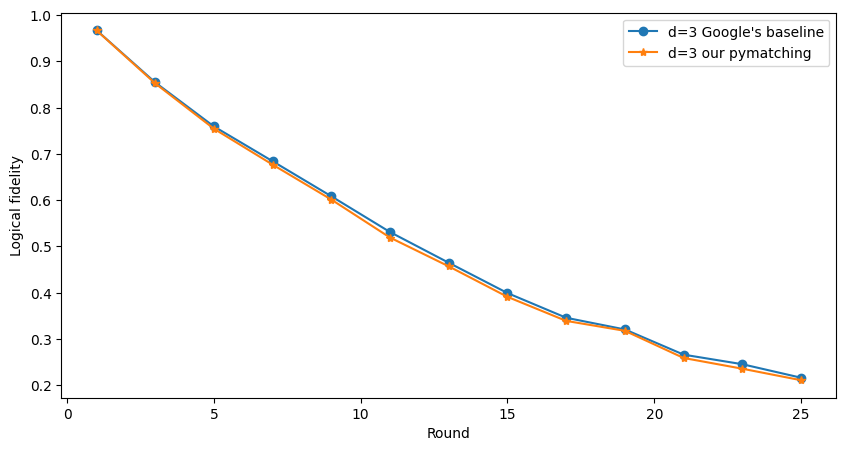

In [74]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(all_rounds, d3_baseline["belief_matching"], label="d=3 Google's baseline", marker='o')
ax.plot(all_rounds, beliefmatching_fidelities_d3, label="d=3 our pymatching", marker='*')
ax.set_xlabel("Round")
ax.set_ylabel("Logical fidelity")
ax.legend()

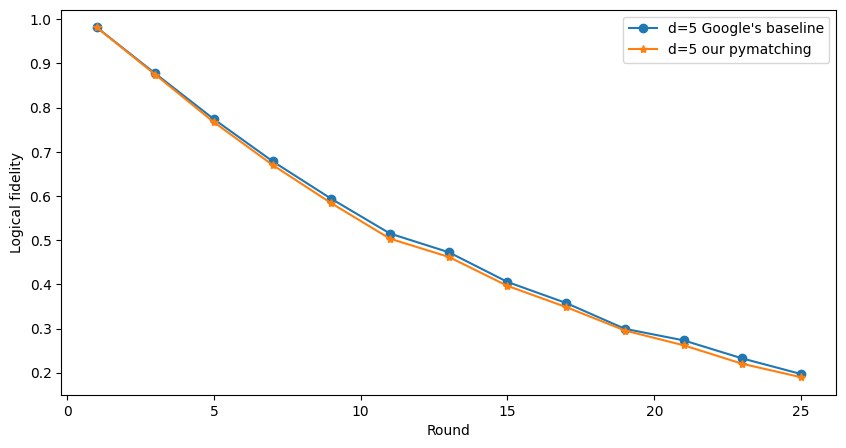

In [73]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(all_rounds, d5_baseline["belief_matching"], label="d=5 Google's baseline", marker='o')
ax.plot(all_rounds, beliefmatching_fidelities_d5, label="d=5 our pymatching", marker='*')
ax.set_xlabel("Round")
ax.set_ylabel("Logical fidelity")
ax.legend()
